# Yolo v3 Object Detection in Tensorflow

## Import Libraries

In [1]:
from PIL import Image
from os import path, makedirs
import os
import re
import pandas as pd
import sys
import argparse

### Read Training Data(Annotations)

In [2]:
df = pd.read_csv("/sg/TrainYourOwnYOLO/Data/Source_Images/Training_Images/vott-csv-export/Annotations-export.csv")

In [3]:
df.head()

,image,xmin,ymin,xmax,ymax,label
0,9k_%20(1).jpg,79.574329,3.017903,215.089195,143.721290,Cat_Face
1,9k_%20(2).jpg,59.437106,6.045714,174.326662,126.434286,Cat_Face
2,2Q__%20(1).jpg,26.523568,15.133689,106.929659,87.180228,Cat_Face
3,2Q__%20(2).jpg,86.635511,2.300571,196.617330,124.230857,Cat_Face
4,2Q__.jpg,3.457861,0.886857,106.126525,103.318857,Cat_Face


## Image Annotation

Convert to Yolo format

In [4]:
parent_dir = "/sg/TrainYourOwnYOLO/" #Change this directory according to your container mount path

sys.path.append(os.path.join(parent_dir, "Utils"))
from Convert_Format import convert_vott_csv_to_yolo

Data_Folder = os.path.join(parent_dir, "Data")
VoTT_Folder = os.path.join(Data_Folder, "Source_Images", "Training_Images", "vott-csv-export")
VoTT_csv = os.path.join(VoTT_Folder, "Annotations-export.csv")
YOLO_filename = os.path.join(VoTT_Folder, "data_train.txt")

model_folder = os.path.join(Data_Folder, "Model_Weights")
classes_filename = os.path.join(model_folder, "data_classes.txt")

# Prepare the dataset for YOLO
multi_df = pd.read_csv(VoTT_csv)
labels = multi_df["label"].unique()
labeldict = dict(zip(labels, range(len(labels))))
multi_df.drop_duplicates(subset=None, keep="first", inplace=True)
train_path = VoTT_Folder
convert_vott_csv_to_yolo(
    multi_df, labeldict, path=train_path, target_name=YOLO_filename
)

# Make classes file
file = open(classes_filename, "w")

# Sort Dict by Values
SortedLabelDict = sorted(labeldict.items(), key=lambda x: x[1])
for elem in SortedLabelDict:
    file.write(elem[0] + "\n")
file.close()

### Load data_train.txt i.e. Yolo_format

In [5]:
with open("/sg/TrainYourOwnYOLO/Data/Source_Images/Training_Images/vott-csv-export/data_train.txt","r") as f:
    data = f.read()

In [6]:
print(data[:501])

/sg/TrainYourOwnYOLO/Data/Source_Images/Training_Images/vott-csv-export/9k_%20(1).jpg 80,3,215,144,0
/sg/TrainYourOwnYOLO/Data/Source_Images/Training_Images/vott-csv-export/9k_%20(2).jpg 59,6,174,126,0
/sg/TrainYourOwnYOLO/Data/Source_Images/Training_Images/vott-csv-export/2Q__%20(1).jpg 27,15,107,87,0
/sg/TrainYourOwnYOLO/Data/Source_Images/Training_Images/vott-csv-export/2Q__%20(2).jpg 87,2,197,124,0
/sg/TrainYourOwnYOLO/Data/Source_Images/Training_Images/vott-csv-export/2Q__.jpg 3,1,106,103,0



## Training

In [7]:
import os
import sys
import argparse

def get_parent_dir(n=1):
    """ returns the n-th parent dicrectory of the current
    working directory """
    current_path = os.path.dirname(os.path.abspath("/sg/TrainYourOwnYOLO/2_Training/Train_YOLO.py"))
    for k in range(n):
        current_path = os.path.dirname(current_path)
    return current_path


src_path = os.path.join(get_parent_dir(0), "src")
sys.path.append(src_path)

utils_path = os.path.join(get_parent_dir(1), "Utils")
sys.path.append(utils_path)

import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import (
    TensorBoard,
    ModelCheckpoint,
    ReduceLROnPlateau,
    EarlyStopping,
)
from keras_yolo3.yolo3.model import (
    preprocess_true_boxes,
    yolo_body,
    tiny_yolo_body,
    yolo_loss,
)
from keras_yolo3.yolo3.utils import get_random_data
from PIL import Image
from time import time
import pickle

from Train_Utils import (
    get_classes,
    get_anchors,
    create_model,
    create_tiny_model,
    data_generator,
    data_generator_wrapper,
    ChangeToOtherMachine,
)


keras_path = os.path.join(src_path, "keras_yolo3")
Data_Folder = os.path.join(get_parent_dir(1), "Data")
Image_Folder = os.path.join(Data_Folder, "Source_Images", "Training_Images")
VoTT_Folder = os.path.join(Image_Folder, "vott-csv-export")
YOLO_filename = os.path.join(VoTT_Folder, "data_train.txt")

Model_Folder = os.path.join(Data_Folder, "Model_Weights")
YOLO_classname = os.path.join(Model_Folder, "data_classes.txt")
log_dir = Model_Folder
anchors_path = os.path.join(keras_path, "model_data", "yolo_anchors.txt")
weights_path = os.path.join(keras_path, "yolo.h5")

Using TensorFlow backend.


In [8]:
YOLO_classname

'/sg/TrainYourOwnYOLO/Data/Model_Weights/data_classes.txt'

In [9]:
#Create Model

class_names = get_classes(YOLO_classname)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
weights_path = weights_path

input_shape = (416, 416)  # multiple of 32, height, width
epoch1, epoch2 = 50, 50

# Create model to train from scratch
# make sure you know what you freeze


model = create_model(
    input_shape, anchors, num_classes, freeze_body=2, weights_path=weights_path)  
log_dir_time = os.path.join(log_dir, "{}".format(int(time())))
logging = TensorBoard(log_dir=log_dir_time)
checkpoint = ModelCheckpoint(
    os.path.join(log_dir, "checkpoint.h5"),
    monitor="val_loss",
    save_weights_only=True,
    save_best_only=True,
    period=5,
)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=10, verbose=1
)

W0723 22:33:22.140749 139913984030528 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0723 22:33:22.142518 139913984030528 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0723 22:33:22.151165 139913984030528 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 22:33:22.152331 139913984030528 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 22:33:22.159435 13

Create YOLOv3 model with 9 anchors and 1 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 18) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((18,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 18) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((18,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights /sg/TrainYourOwnYOLO/2_Training/src/keras_yolo3/yolo.h5.
Freeze the first 249 layers of total 252 layers.


### Train Val Split

In [10]:
#10% Validation, 90% Training
val_split = 0.1 
with open(YOLO_filename) as f:
    lines = f.readlines()

# This step makes sure that the path names correspond to the local machine
np.random.shuffle(lines)
num_val = int(len(lines) * val_split)
num_train = len(lines) - num_val

In [11]:
# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a decent model.
model.compile(
    optimizer=Adam(lr=1e-3),
    loss={
        # use custom yolo_loss Lambda layer.
        "yolo_loss": lambda y_true, y_pred: y_pred
    },
)

batch_size = 32
print("Train on {} samples, val on {} samples, with batch size {}.".format(
        num_train, num_val, batch_size))

W0723 22:33:34.225338 139913984030528 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Train on 90 samples, val on 10 samples, with batch size 32.


In [12]:
# Using fit_generator to train the model

history = model.fit_generator(
    data_generator_wrapper(
        lines[:num_train], batch_size, input_shape, anchors, num_classes
    ),
    steps_per_epoch=max(1, num_train // batch_size),
    validation_data=data_generator_wrapper(
        lines[num_train:], batch_size, input_shape, anchors, num_classes
    ),
    validation_steps=max(1, num_val // batch_size),
    epochs=epoch1,
    initial_epoch=0,
    callbacks=[logging, checkpoint],
)

W0723 22:33:36.854525 139913984030528 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0723 22:33:36.913237 139913984030528 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0723 22:33:37.746536 139913984030528 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0723 22:33:37.747706 139913984030528 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/50
2/2 [==============================] - 16s 8s/step - loss: 11294.6250 - val_loss: 9927.3135


W0723 22:33:55.398992 139913984030528 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:995: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.



Epoch 2/50
2/2 [==============================] - 12s 6s/step - loss: 9651.1934 - val_loss: 8186.3706
Epoch 3/50
2/2 [==============================] - 12s 6s/step - loss: 8052.5688 - val_loss: 6730.1973
Epoch 4/50
2/2 [==============================] - 11s 6s/step - loss: 6648.3274 - val_loss: 5662.0439
Epoch 5/50
2/2 [==============================] - 11s 6s/step - loss: 5475.5920 - val_loss: 4555.0493
Epoch 6/50
2/2 [==============================] - 11s 6s/step - loss: 4535.8518 - val_loss: 3826.6960
Epoch 7/50
2/2 [==============================] - 11s 6s/step - loss: 3727.7737 - val_loss: 3003.3455
Epoch 8/50
2/2 [==============================] - 11s 6s/step - loss: 3083.3555 - val_loss: 2647.5815
Epoch 9/50
2/2 [==============================] - 11s 6s/step - loss: 2529.2092 - val_loss: 2219.8372
Epoch 10/50
2/2 [==============================] - 11s 6s/step - loss: 2121.3937 - val_loss: 1627.9742
Epoch 11/50
2/2 [==============================] - 11s 6s/step - loss: 1741.3849 

In [13]:
# Save model history 
model.save_weights(os.path.join(log_dir, "trained_weights_stage_1.h5"))
step1_train_loss = history.history["loss"]

file = open(os.path.join(log_dir_time, "step1_loss.npy"), "w")
with open(os.path.join(log_dir_time, "step1_loss.npy"), "w") as f:
    for item in step1_train_loss:
        f.write("%s\n" % item)
file.close()

step1_val_loss = np.array(history.history["val_loss"])

file = open(os.path.join(log_dir_time, "step1_val_loss.npy"), "w")
with open(os.path.join(log_dir_time, "step1_val_loss.npy"), "w") as f:
    for item in step1_val_loss:
        f.write("%s\n" % item)
file.close()

### Plotting Loss

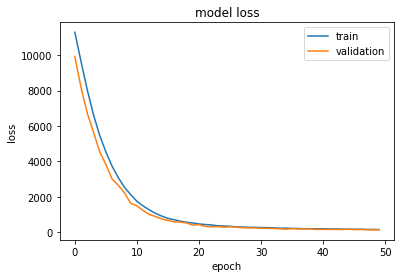

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
# "Loss"
plt.plot(step1_train_loss)
plt.plot(step1_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

In [15]:
# Unfreeze and continue training, to fine-tune.
# Train longer if the result is unsatisfactory.
if True:
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
model.compile(optimizer=Adam(lr=1e-4), loss={"yolo_loss": lambda y_true, y_pred: y_pred})  # recompile to apply the change
print("Unfreeze all layers.")
batch_size = (4)  # note that more GPU memory is required after unfreezing the body)
print("Train on {} samples, val on {} samples, with batch size {}.".format(num_train, num_val, batch_size))

Unfreeze all layers.
Train on 90 samples, val on 10 samples, with batch size 4.


In [16]:
# Train every layer of the model
history = model.fit_generator(
    data_generator_wrapper(
        lines[:num_train], batch_size, input_shape, anchors, num_classes
    ),
    steps_per_epoch=max(1, num_train // batch_size),
    validation_data=data_generator_wrapper(
        lines[num_train:], batch_size, input_shape, anchors, num_classes
    ),
    validation_steps=max(1, num_val // batch_size),
    epochs=epoch1 + epoch2,
    initial_epoch=epoch1,
    callbacks=[logging, checkpoint, reduce_lr, early_stopping],
)

model.save_weights(os.path.join(log_dir, "trained_weights_final.h5"))

Epoch 51/100
22/22 [==============================] - 54s 2s/step - loss: 61.6726 - val_loss: 59.5432
Epoch 52/100
22/22 [==============================] - 45s 2s/step - loss: 36.6713 - val_loss: 38.6462
Epoch 53/100
22/22 [==============================] - 45s 2s/step - loss: 28.8773 - val_loss: 30.0127
Epoch 54/100
22/22 [==============================] - 45s 2s/step - loss: 25.1006 - val_loss: 27.2228
Epoch 55/100
22/22 [==============================] - 45s 2s/step - loss: 23.2064 - val_loss: 24.0131
Epoch 56/100
22/22 [==============================] - 45s 2s/step - loss: 20.8159 - val_loss: 25.3028
Epoch 57/100
22/22 [==============================] - 45s 2s/step - loss: 20.0912 - val_loss: 24.4296
Epoch 58/100
22/22 [==============================] - 45s 2s/step - loss: 19.2592 - val_loss: 25.2970

Epoch 00058: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 59/100
22/22 [==============================] - 45s 2s/step - loss: 18.1837 - val_loss: 17.2806
E

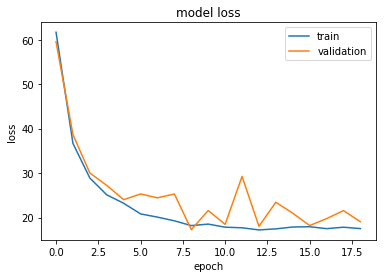

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
# "Loss"
step2_train_loss = history.history["loss"]
step2_val_loss = np.array(history.history["val_loss"])
plt.plot(step2_train_loss)
plt.plot(step2_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

## Inference

In [18]:
# Append paths to import libraries
sys.path.append(src_path)
sys.path.append(utils_path)

In [19]:
import argparse
from keras_yolo3.yolo import YOLO, detect_video
from PIL import Image,ImageFont,ImageDraw
from timeit import default_timer as timer
from utils import load_extractor_model, load_features, parse_input, detect_object
import test
import utils
import pandas as pd
import numpy as np
from Get_File_Paths import GetFileList
import random

In [20]:
print(get_parent_dir(0))
print( get_parent_dir(1))

/sg/TrainYourOwnYOLO/2_Training
/sg/TrainYourOwnYOLO


### Join paths of concerned folders

In [21]:
# Set up folder names for default values
data_folder = os.path.join(get_parent_dir(n=1), "Data")

image_folder = os.path.join(data_folder, "Source_Images")

image_test_folder = os.path.join(image_folder, "Test_Images")

detection_results_folder = os.path.join(image_folder, "Test_Image_Detection_Results")
detection_results_file = os.path.join(detection_results_folder, "Detection_Results.csv")

model_folder = os.path.join(data_folder, "Model_Weights")

model_weights = os.path.join(model_folder, "trained_weights_final.h5")
model_classes = os.path.join(model_folder, "data_classes.txt")
anchors_path = os.path.join(src_path, "keras_yolo3", "model_data", "yolo_anchors.txt")
output_path = detection_results_folder
if not os.path.exists(output_path):
    os.makedirs(output_path)

### Load Yolo model with train_weights

In [22]:
yolo = YOLO(
    **{
        "model_path": model_weights,
        "anchors_path": anchors_path,
        "classes_path": model_classes,
        "score": 0.5,
        "gpu_num": 1,
        "model_image_size": (416, 416),
    }
)

/sg/TrainYourOwnYOLO/Data/Model_Weights/trained_weights_final.h5 model, anchors, and classes loaded in 10.20sec.


In [23]:
# labels to draw on images
class_file = open(model_classes, "r")
input_labels = [line.rstrip("\n") for line in class_file.readlines()]
print("Found {} input labels: {} ...".format(len(input_labels), input_labels))

Found 1 input labels: ['Cat_Face'] ...


In [24]:
def detect_object(yolo, img_path, save_img, save_img_path="./"):
    """
    Call YOLO logo detector on input image, optionally save resulting image.

    Args:
      yolo: keras-yolo3 initialized YOLO instance
      img_path: path to image file
      save_img: bool to save annotated image
      save_img_path: path to directory where to save image
    Returns:
      prediction: list of bounding boxes in format (xmin,ymin,xmax,ymax,class_id,confidence)
      image: unaltered input image as (H,W,C) array
    """
    try:
        image = Image.open(img_path)
        if image.mode != "RGB":
            image = image.convert("RGB")
        image_array = np.array(image)
    except:
        print("File Open Error! Try again!")
        return None, None

    prediction, new_image, out_boxes, out_scores, out_classes = yolo.detect_image(image)

    return prediction, image_array, new_image, out_boxes, out_scores, out_classes

### Load an image to test

In [25]:
img_path= "/sg/TrainYourOwnYOLO/Data/Source_Images/Test_Images/0_Cat_research.jpg"
prediction, image_array, new_image, out_boxes, out_scores, out_classes = detect_object(
    yolo,
    img_path,
    save_img=True,
    save_img_path=output_path,
)
y_size, x_size, _ = np.array(image_array).shape

(416, 416, 3)
Found 1 boxes for img
Cat_Face 0.74 (249, 6) (448, 147)
Time spent: 1.989sec


In [26]:
image = Image.open(img_path)
font_path = os.path.join("/sg/TrainYourOwnYOLO/2_Training/src/keras_yolo3/font/FiraMono-Medium.otf")
font = ImageFont.truetype(
    font=font_path, size=np.floor(3e-2 * image.size[1] + 0.5).astype("int32")
)
thickness = (image.size[0] + image.size[1]) // 300

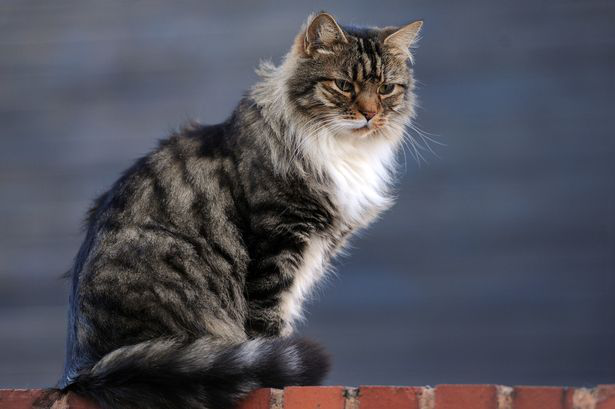

In [27]:
image

### Image draw object
Using ImageDraw object to draw bounding box over input image

In [28]:
from PIL import ImageDraw
draw = ImageDraw.Draw(image)
print(draw)

In [29]:
# Loop over classes(detect multiple objects in an image)
for i, c in reversed(list(enumerate(out_classes))):
    predicted_class = yolo.class_names[c]
    box = out_boxes[i]
    score = out_scores[i]

    label = "{} {:.2f}".format(predicted_class, score)
    draw = ImageDraw.Draw(image)
    label_size = draw.textsize(label, font)

    top, left, bottom, right = box
    top = max(0, np.floor(top + 0.5).astype("int32"))
    left = max(0, np.floor(left + 0.5).astype("int32"))
    bottom = min(image.size[1], np.floor(bottom + 0.5).astype("int32"))
    right = min(image.size[0], np.floor(right + 0.5).astype("int32"))

    # image was expanded to model_image_size: make sure it did not pick
    # up any box outside of original image (run into this bug when
    # lowering confidence threshold to 0.01)
    if top > image.size[1] or right > image.size[0]:
        continue

    if top - label_size[1] >= 0:
        text_origin = np.array([left, top - label_size[1]])
    else:
        text_origin = np.array([left, bottom])

    # My kingdom for a good redistributable image drawing library.
    for i in range(thickness):
        draw.rectangle(
            [left + i, top + i, right - i, bottom - i], outline=yolo.colors[c]
        )
    draw.rectangle(
        [tuple(text_origin), tuple(text_origin + label_size)],
        fill=yolo.colors[c],
    )

    draw.text(text_origin, label, fill=(0, 0, 0), font=font)
    del draw

In [30]:
# top, left, bottom, right
print(out_boxes)
print(image.size)

[[  6.315235 248.8839   147.31409  448.4713  ]]
(615, 409)


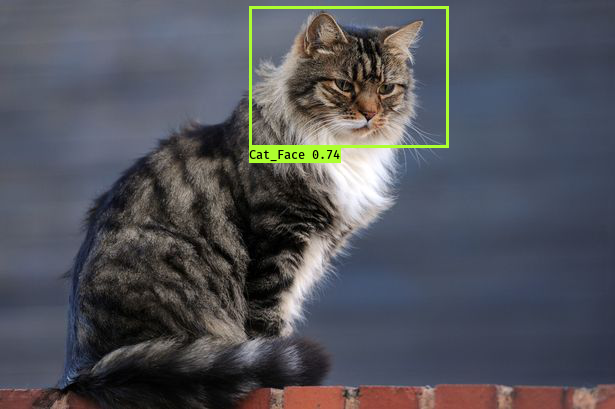

In [35]:
image

### Loading another image to test

In [31]:
img_path= "/sg/TrainYourOwnYOLO/Data/Source_Images/Training_Images/vott-csv-export/images%20(15).jpg"
cat = Image.open(img_path)
prediction, image_array, new_image, out_boxes, out_scores, out_classes = detect_object(
    yolo,
    img_path,
    save_img=True,
    save_img_path=output_path,
)
y_size, x_size, _ = np.array(image_array).shape

(416, 416, 3)
Found 2 boxes for img
Cat_Face 0.63 (65, 71) (191, 181)
Cat_Face 0.92 (31, 4) (136, 121)
Time spent: 0.150sec


In [32]:
output_path

'/sg/TrainYourOwnYOLO/Data/Source_Images/Test_Image_Detection_Results'

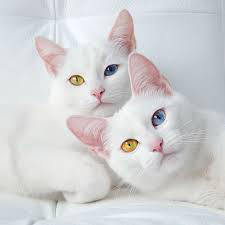

In [33]:
cat

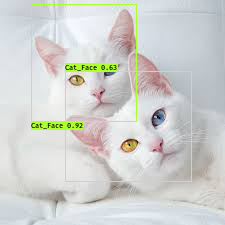

In [34]:
new_image